In [ ]:
# CONFIG:
MODEL_PATH = 'models/model_360_epoch-2_kappa-0.653.pt'
MODEL_PATH = 'models/model_512px_epoch-9_kappa-0.676.pt'
MODEL_PATH = 'models/model_512px_epoch-17_kappa-0.651.pt'
MODEL_PATH = 'models/model_512px_epoch-12_kappa-0.645.pt'
MODEL_PATH = 'models/model_512px_epoch-11_kappa-0.624.pt'

MODELS_FOLDER = 'models/'
# LIST_ENSEMBLE_MODELS = ['model_360_epoch-2_kappa-0.653.pt']#, 'model_360_epoch-1_kappa-0.648.pt', 'model_360_epoch-3_kappa-0.64.pt']
# LIST_ENSEMBLE_MODELS = ['model_512px_epoch-9_kappa-0.676.pt']#, 'model_360_epoch-3_kappa-0.64.pt']
LIST_ENSEMBLE_MODELS = ['model_512px_epoch-9_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-8_kappa-0.672.pt', 'model_360px_epoch-7_kappa-0.67.pt']#, 'model_512px_epoch-6_kappa-0.651.pt', 'model_512px_epoch-17_kappa-0.651.pt']
# LIST_ENSEMBLE_MODELS = ['model_360px_epoch-4_kappa-0.663.pt', 'model_360_epoch-2_kappa-0.653.pt']
LIST_ENSEMBLE_MODELS = ['model_360px_epoch-4_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-8_kappa-0.672.pt', 'model_360px_epoch-7_kappa-0.67.pt'] #['model_360px_epoch-4_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-8_kappa-0.672.pt', 'model_360px_epoch-7_kappa-0.67.pt', 'model_360px_epoch-1_kappa-0.672.pt'] #['model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-4_kappa-0.676.pt']

LIST_ENSEMBLE_MODELS = [MODELS_FOLDER+path for path in LIST_ENSEMBLE_MODELS]



# INPUT_SIZE = 512 #360
# CHANGE IT IN CONFIG FILE!

BY_CATEGORIES = False

single_model_14 = False#True

/home/bohdan/work/ml/programs/anaconda3/envs/bone/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/329 [00:00<?, ?it/s]

valid_df shape: (329, 3)


100%|██████████| 329/329 [00:58<00:00,  5.58it/s]


Few images with shape: (360, 360)


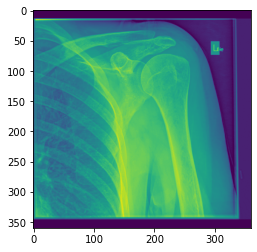

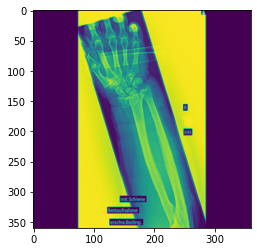

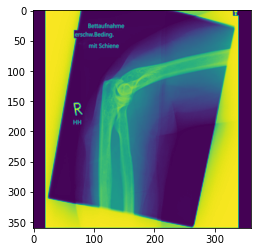

Loaded 329 images and 329 labels for the current dataset
unique studies: 329


In [2]:
import time
import cv2
import argparse
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
# from tensorboard_utils import *

from model import PretrainedDensenet
from read_data import Data
from data_utils import *#MuraDataset
from train import *
from loss import Loss
from visualize import see_samples, view_data_count

device = torch.device("cuda")

df = Data()
valid_df = df.valid_df #.pallace_valid_df


print("valid_df shape:", valid_df.shape)
body_type = 'WRIST'
# valid_df = valid_df[valid_df['BodyPart']==body_type]

    
if not single_model_14:
    val_dataset = MuraDataset(df=valid_df, is_train=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0, shuffle=False)#, pin_memory=True)

# if not single_model_14:
#     model = PretrainedDensenet()
#     model.to(device)
# #     model.load_state_dict(torch.load(MODEL_PATH))
#     model.eval()

valid_df['study'] = valid_df['FilePath'].apply(lambda x: '/'.join(x.split('/')[:-1]))
print("unique studies:", valid_df['study'].nunique())

original_valid_df = valid_df.copy()

In [3]:
if single_model_14:
    from best_single import *

In [4]:
# Eval single 
def eval_trained_model(model):
    with torch.no_grad():
        model.eval()
        list_outputs = []
        list_labels = []
        for images, labels in tqdm(val_loader):
            images, labels = Variable(images.to(device)), Variable(labels.to(device))
            labels = labels.view(-1,1)

            output = model(images)

            # save output and labels for kappa_score
            outputs = output.cpu().numpy() # np.where(output.cpu().numpy() >= 0.5, 1, 0)
            list_outputs.extend(outputs.tolist())
    list_outputs = [el[0] for el in list_outputs]
    return list_outputs

In [5]:
# Eval single 
def eval_single14():
    list_outputs = []
    for FilePath in tqdm(valid_df['FilePath'].values):
        image = cv2.imread(FilePath)
        output = predict_image(image)
        list_outputs.append(output)
    return list_outputs


In [6]:
# INIT MODELS
list_models = []
for model_path in LIST_ENSEMBLE_MODELS:
    model = PretrainedDensenet()
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    list_models.append(model)
    print("model_path:", model_path)
    


model_path: models/model_360px_epoch-4_kappa-0.676.pt
model_path: models/model_360_epoch-2_kappa-0.653.pt
model_path: models/model_360px_epoch-8_kappa-0.672.pt
model_path: models/model_360px_epoch-7_kappa-0.67.pt


15

In [7]:
valid_df = original_valid_df

In [8]:
print(" Predicting for validation dataset with size of {0}*{0}".format(str(INPUT_SIZE)))

# predict all models
list_models_outputs = []
for model in list_models:
    list_outputs = eval_trained_model(model)
    list_models_outputs.append(list_outputs)
#     print("list_outputs:", list_outputs)

list_outputs_global = []

print(len(list_models_outputs[0]))
CNT = 0
for output_idx in range(len(list_models_outputs[0])):
    CNT += 1
    output = np.array([list_output_single[output_idx] for list_output_single in list_models_outputs]).mean()
    if CNT < 20:
        print("list_models:{} , output:{}".format([list_output_single[output_idx] for list_output_single in list_models_outputs], output))
    

    list_outputs_global.append(output)
    
list_outputs = list_outputs_global


  0%|          | 1/329 [00:00<00:47,  6.90it/s]

 Predicting for validation dataset with size of 360*360


100%|██████████| 329/329 [00:07<00:00, 44.35it/s]

329
list_models:[0.7746039628982544, 0.7556573748588562, 0.39690831303596497, 0.32854682207107544] , output:0.5639291182160378
list_models:[0.024333406239748, 0.01953652687370777, 0.005625160411000252, 0.0044736010022461414] , output:0.013492173631675541
list_models:[0.028325391933321953, 0.02869831770658493, 0.012581175193190575, 0.013742617331445217] , output:0.02083687554113567
list_models:[0.06614211201667786, 0.04703536629676819, 0.042308419942855835, 0.055791355669498444] , output:0.05281931348145008
list_models:[0.4462006688117981, 0.713587760925293, 0.4894680380821228, 0.33785301446914673] , output:0.49677737057209015
list_models:[0.10419423878192902, 0.5201988220214844, 0.5864010453224182, 0.68843674659729] , output:0.4748077131807804
list_models:[0.505165159702301, 0.25096964836120605, 0.045151542872190475, 0.05811331048607826] , output:0.21484991535544395
list_models:[0.7534188032150269, 0.8847657442092896, 0.8195973634719849, 0.8093471527099609] , output:0.8167822659015656


In [9]:
# Calculate average prediction for the whole study

valid_df['single_pred'] = list_outputs

valid_df_grouped = valid_df.groupby('study', as_index=False)['single_pred'].agg(np.mean)
valid_df = valid_df.merge(valid_df_grouped, left_on='study', right_on='study',
          suffixes=('', '_mean'))

valid_df_study = valid_df.drop_duplicates('study').reset_index()
avg_pred_label = [1 if x >=0.5 else 0 for x in valid_df_study['single_pred_mean'].to_list()]
valid_df_study['avg_pred_label'] = avg_pred_label

print("valid_df_study.shape:", valid_df_study.shape)
valid_df_study.head()

valid_df_study.shape: (329, 8)


,index,Unnamed: 0,FilePath,Label,study,single_pred,single_pred_mean,avg_pred_label
0,0,0,../data/input/Pallace_data/images/1_1/81110509...,1,../data/input/Pallace_data/images/1_1,0.563929,0.563929,1
1,1,1,../data/input/Pallace_data/images/2_1/fc736418...,1,../data/input/Pallace_data/images/2_1,0.013492,0.013492,0
2,2,2,../data/input/Pallace_data/images/3_0/c9d1d5c9...,0,../data/input/Pallace_data/images/3_0,0.020837,0.020837,0
3,3,3,../data/input/Pallace_data/images/4_0/bb71544f...,0,../data/input/Pallace_data/images/4_0,0.052819,0.052819,0
4,4,4,../data/input/Pallace_data/images/5_0/bf9b0261...,0,../data/input/Pallace_data/images/5_0,0.496777,0.496777,0


In [10]:
list_outputs = valid_df_study['avg_pred_label'].to_list()
list_labels = valid_df_study['Label'].to_list()

print("LEN list_outputs:", len(list_outputs))

# -------------------------- metrics
# Kappa statistics
kappa_score = cohen_kappa_score(list_outputs, list_labels)
# AUC ROC
auc_roc_score = roc_auc_score(list_outputs, list_labels)
# accuracy
accuracy = accuracy_score(list_outputs, list_labels)

print (f"\nKappa score : {kappa_score} \nAUC ROC score : {auc_roc_score} \nAccuracy : {accuracy}")

LEN list_outputs: 329

Kappa score : 0.15148052626424202 
AUC ROC score : 0.5896791650560494 
Accuracy : 0.5197568389057751


In [11]:
# Kappa score : 0.28829630228655756 
# AUC ROC score : 0.6342547262182723 
# Accuracy : 0.6747720364741642

In [12]:
# ensemble 3 epochs 360px
# Kappa score : 0.686122081972251 
# AUC ROC score : 0.8518781192540058 
# Accuracy : 0.8465387823185988
# ​
# 2 worse models
# Kappa score : 0.6823768682331293 
# AUC ROC score : 0.8512197982641334 
# Accuracy : 0.8448707256046706

In [13]:
# model_512px_epoch-9_kappa-0.676.pt
# Kappa score : 0.6600182609040849 
# AUC ROC score : 0.8350018709881696 
# Accuracy : 0.8331943286071727

In [14]:
# 360*360 input with models from 512*512 ensemble ['model_512px_epoch-9_kappa-0.676.pt', 'model_512px_epoch-6_kappa-0.651.pt', 'model_512px_epoch-17_kappa-0.651.pt']
# Kappa score : 0.6715555910652529 
# AUC ROC score : 0.8479111846968039 
# Accuracy : 0.8398665554628857


# 512*512 input with models from 512*512 ensemble ['model_512px_epoch-9_kappa-0.676.pt', 'model_512px_epoch-6_kappa-0.651.pt', 'model_512px_epoch-17_kappa-0.651.pt']
# Kappa score : 0.7051445158190557 
# AUC ROC score : 0.8606135504507124 
# Accuracy : 0.8557130942452044

# 512*512 input for ['model_512px_epoch-9_kappa-0.676.pt'] solo
# Kappa score : 0.6907244840400353 
# AUC ROC score : 0.8502719609940088 
# Accuracy : 0.8482068390325271




In [15]:
# 360*360  ['model_360px_epoch-4_kappa-0.663.pt']
# just one epoch after 'model_360_epoch-2_kappa-0.653.pt'
# Kappa score : 0.6921554748263383 
# AUC ROC score : 0.8518042129063517 
# Accuracy : 0.8490408673894912

# ['model_360px_epoch-4_kappa-0.663.pt', 'model_360_epoch-2_kappa-0.653.pt']
# Kappa score : 0.6953444499489687 
# AUC ROC score : 0.8541138947684978 
# Accuracy : 0.8507089241034195

#  ['model_360px_epoch-8_kappa-0.672.pt', 'model_360px_epoch-7_kappa-0.67.pt']
#     Kappa score : 0.7030767435306977 
# AUC ROC score : 0.8609971120231038 
# Accuracy : 0.8548790658882403




In [16]:
 # 360*360 ['model_512px_epoch-9_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-8_kappa-0.672.pt', 'model_360px_epoch-7_kappa-0.67.pt']
# Kappa score : 0.6929455149728543 
# AUC ROC score : 0.8553775209409568 
# Accuracy : 0.8498748957464554

# ['model_360px_epoch-4_kappa-0.676.pt']
# Kappa score : 0.7042136229399962 
# AUC ROC score : 0.8640922576040861 
# Accuracy : 0.8557130942452044    

# ['model_360px_epoch-4_kappa-0.676.pt', 'model_512px_epoch-9_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt']
# Kappa score : 0.7041098274388862 
# AUC ROC score : 0.8645279451731064 
# Accuracy : 0.8557130942452044

In [17]:
# ['model_360px_epoch-4_kappa-0.676.pt', 'model_360_epoch-2_kappa-0.653.pt']

# Kappa score : 0.7164305416248746 
# AUC ROC score : 0.8692091490598952 
# Accuracy : 0.8615512927439533

# [model_360_epoch-2_kappa-0.653.pt', 'model_360px_epoch-4_kappa-0.676.pt', 'model_360px_epoch-7_kappa-0.67.pt', 'model_360px_epoch-8_kappa-0.672.pt'] = 1,2,3,4
# Kappa score : 0.7201412985001978 
# AUC ROC score : 0.869758965005203 
# Accuracy : 0.8632193494578816